In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data

## Missing Data

1. Time-level missing data

In [2]:
sheets = {
    "hcpi_a": "annual",
    "fcpi_m": "monthly",
    "ecpi_m": "monthly",
    "ccpi_m": "monthly",
    "ppi_m": "monthly",
    "def_q": "quarterly"
}

file_path = "Inflation-data.xlsx"

missing_summary = {}

for sheet_name, freq in sheets.items():
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Only retain the time column (such as 1980, 199401, etc.)
    time_columns = [col for col in df.columns if isinstance(col, int) or (isinstance(col, str) and col.isdigit())]
    df_time = df[time_columns]

    # The number of missing values
    missing_count = df_time.isna().sum()

    # Total number of countries (number of lines)
    total_countries = df_time.shape[0]

    # Missing rate (in percentage form)
    missing_rate = (missing_count / total_countries * 100).round(2)

    summary_df = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Rate (%)': missing_rate
    })

    missing_summary[sheet_name] = summary_df


for sheet_name, summary in missing_summary.items():
    print(f"=== {sheet_name} ===")
    print(summary)
    print("\n")


=== hcpi_a ===
      Missing Count  Missing Rate (%)
1970             50             24.39
1971             50             24.39
1972             50             24.39
1973             49             23.90
1974             49             23.90
1975             51             24.88
1976             51             24.88
1977             51             24.88
1978             50             24.39
1979             50             24.39
1980             47             22.93
1981             43             20.98
1982             42             20.49
1983             42             20.49
1984             42             20.49
1985             42             20.49
1986             41             20.00
1987             40             19.51
1988             40             19.51
1989             40             19.51
1990             39             19.02
1991             36             17.56
1992             30             14.63
1993             26             12.68
1994             25             12.

2. Country - level missing data

In [3]:
# Define file path and sheet types
sheets = {
    "hcpi_a": "annual",
    "fcpi_m": "monthly",
    "ecpi_m": "monthly",
    "ccpi_m": "monthly",
    "ppi_m": "monthly",
    "def_q": "quarterly"
}

file_path = "Inflation-data.xlsx"
cleaned_data = {}
removed_countries = {}

# Process each sheet
for sheet_name, freq in sheets.items():
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Assume first column is country identifier; the rest are data columns
    id_col = df.columns[0]
    data_cols = df.columns[1:]
    
    # Calculate missing value ratio for each row
    missing_ratio = df[data_cols].isna().mean(axis=1)
    
    # Identify rows to remove (more than 80% missing)
    to_remove = df.loc[missing_ratio > 0.8, id_col].tolist()
    removed_countries[sheet_name] = to_remove
    
    # Keep only rows with 80% or less missing values
    df_cleaned = df[missing_ratio <= 0.8].reset_index(drop=True)
    cleaned_data[sheet_name] = df_cleaned


removed_countries["hcpi_a"][:10]  # Show top 10 removed country names from 'hcpi_a'

['MTQ',
 'NIU',
 nan,
 'Note: For those countries where annual data are not yet available for 2023, annual averages of monthly or quarterly inflation in 2023 with available data or the projections by the IMF World Economic Outlook (April 2024) are included instead. ']

### Implemention

In [4]:
# Load the simplified Excel file
file_path = "Simplified_Inflation_Data.xlsx"
simplified_sheets = pd.read_excel(file_path, sheet_name=None)

filled_sheets = {}
missing_summary = {}

# Apply fill strategy to each sheet
for sheet_name, df in simplified_sheets.items():
    # Identify ID columns
    id_cols = [col for col in df.columns if isinstance(col, str) and ("Country Code" in col or "IMF Country Code" in col)]
    
    # Identify time columns (numeric or string-digit)
    time_cols = [col for col in df.columns if col not in id_cols and str(col).isdigit()]
    
    # Drop rows with very few time data (≤10 non-NA)
    df = df[df[time_cols].notna().sum(axis=1) > 10].reset_index(drop=True)

    # Apply forward fill, backward fill, and linear interpolation row-wise
    df[time_cols] = df[time_cols].apply(
        lambda row: row.ffill().bfill().interpolate(limit_direction='both'), axis=1
    )

    # Store result
    filled_sheets[sheet_name] = df
    missing_summary[sheet_name] = int(df[time_cols].isna().sum().sum())

# Display missing value summary after filling
missing_df = pd.DataFrame(list(missing_summary.items()), columns=["Sheet", "Remaining Missing Values"])


In [5]:
# Check whether there are still missing values in each worksheet
print(missing_df)

    Sheet  Remaining Missing Values
0  hcpi_a                         0
1  fcpi_m                         0
2  ecpi_m                         0
3  ccpi_m                         0
4   ppi_m                         0
5   def_q                         0


## Exploratory Data Analyses

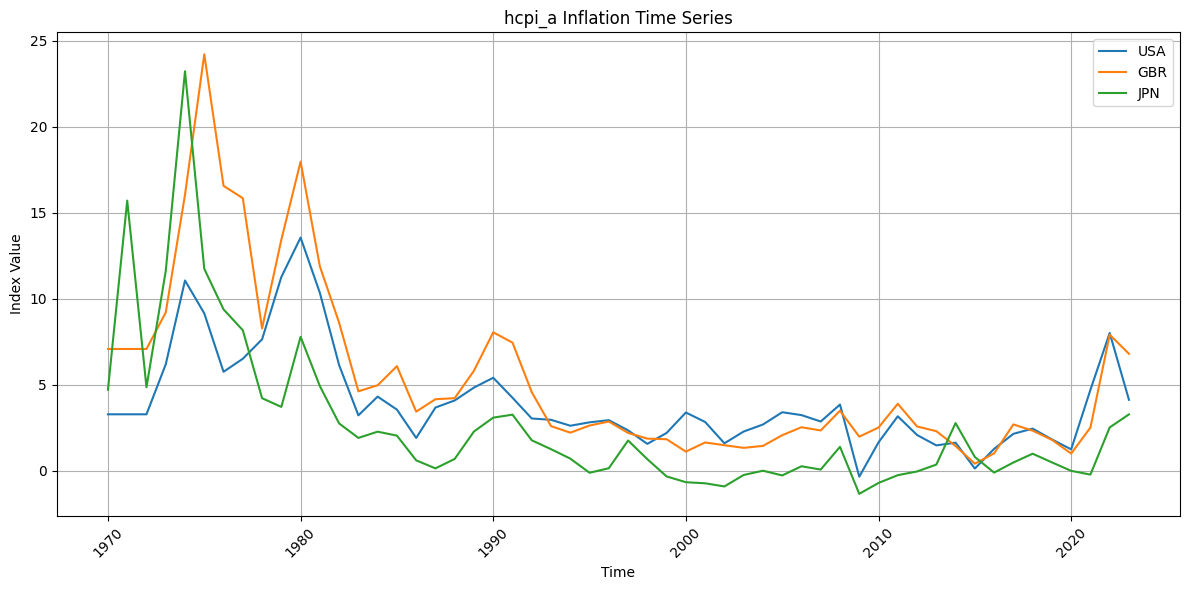

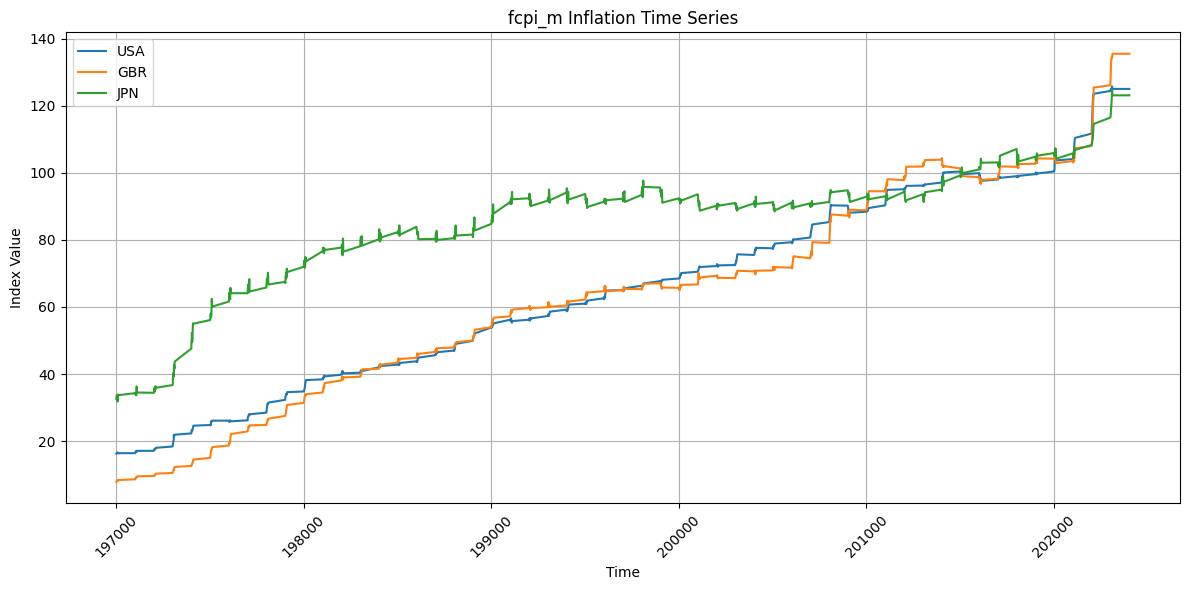

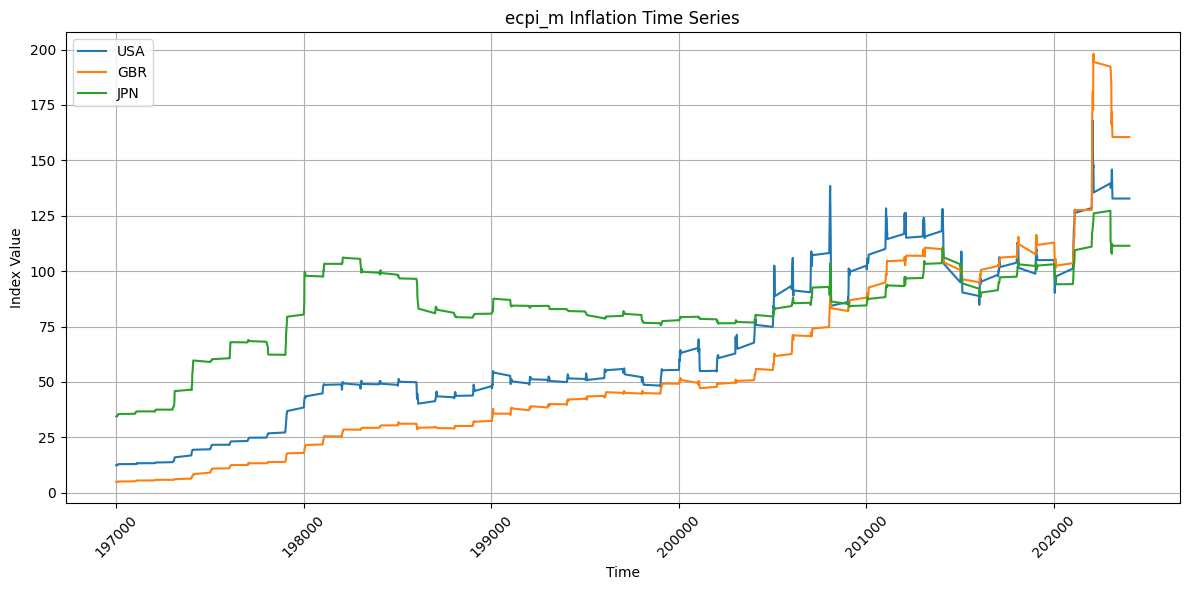

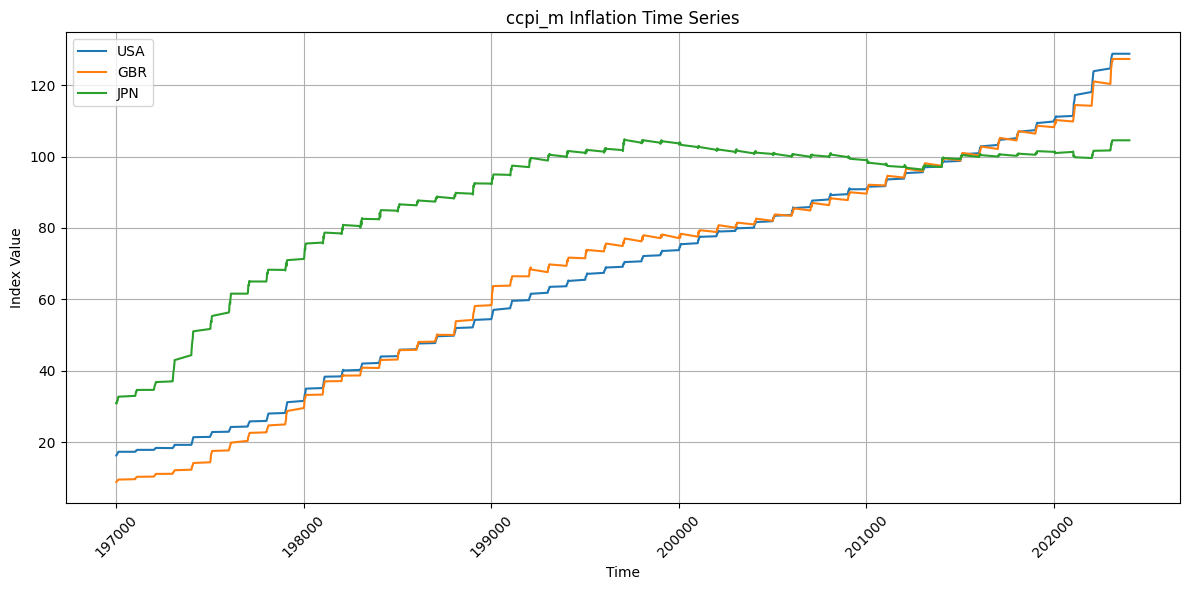

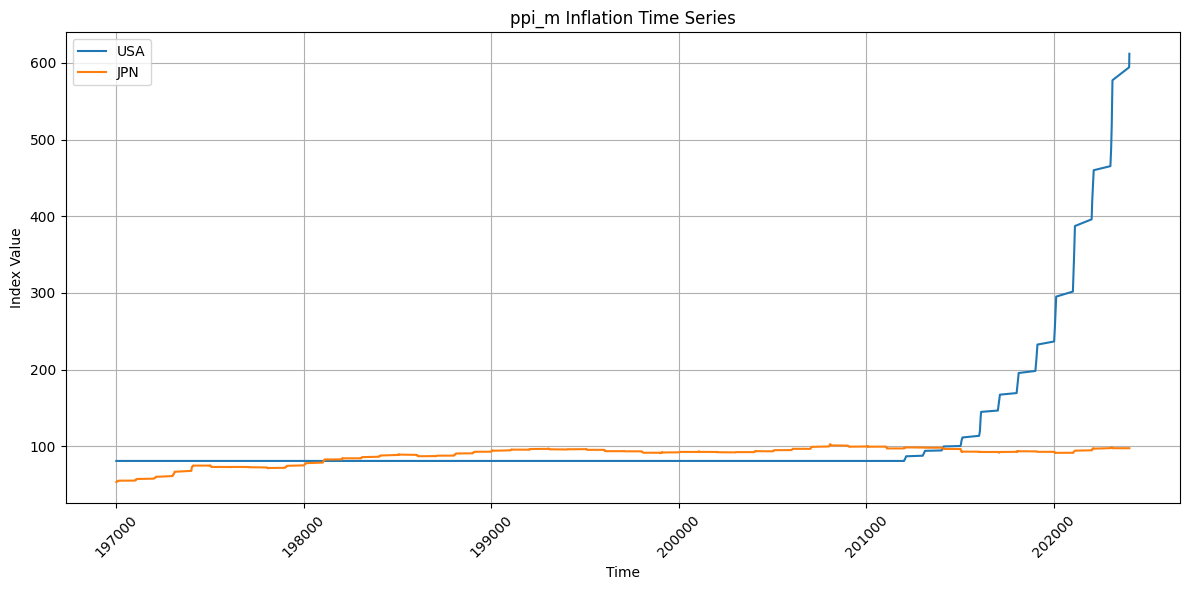

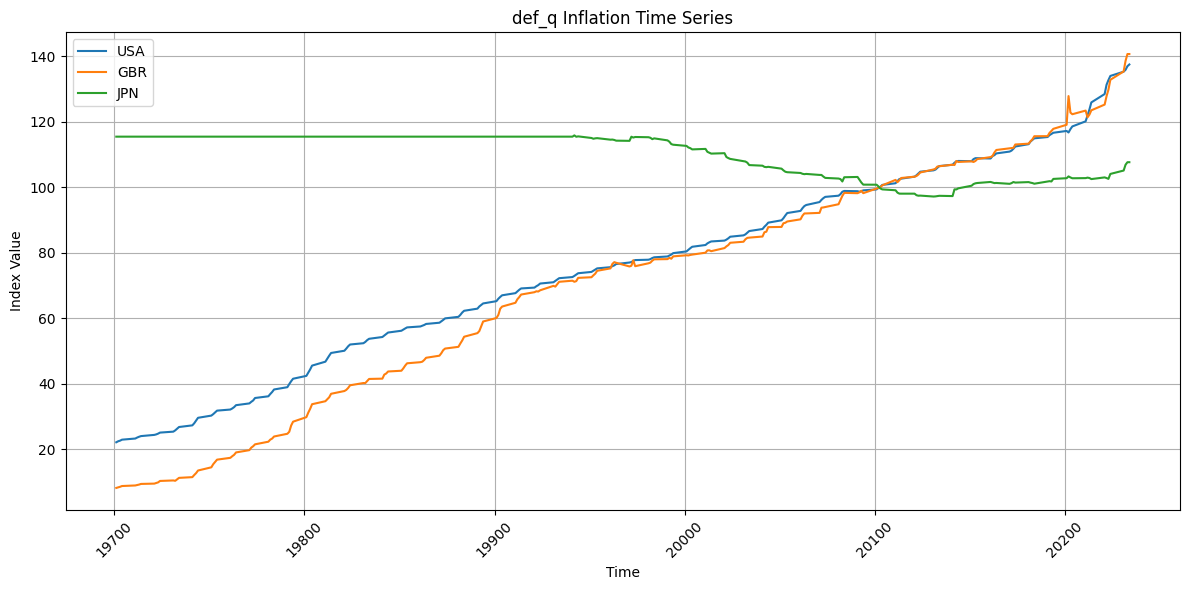

In [6]:
import matplotlib.pyplot as plt
# Load Excel file
file_path = "Filtered_Inflation_Data.xlsx"  # Update with your actual file path
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

# Load all sheets into a dictionary of DataFrames
dfs = {sheet: xls.parse(sheet) for sheet in sheet_names}

# Time series plotting function
def plot_time_series(df, title, countries=['USA', 'GBR', 'JPN', 'CHN']):
    # Filter for selected countries
    df_filtered = df[df['Country Code'].isin(countries)]

    # Detect and select only time-related columns (numeric strings or integers)
    time_cols = [col for col in df.columns if isinstance(col, (int, str)) and str(col).isdigit()]
    time_series = df_filtered[time_cols]
    time_series.index = df_filtered['Country Code']
    time_series = time_series.T  # Transpose for time series format

    # Plotting
    plt.figure(figsize=(12, 6))
    for country in time_series.columns:
        plt.plot(time_series.index, time_series[country], label=country)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Index Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Loop through each sheet and plot the time series
for sheet_name in sheet_names:
    plot_time_series(dfs[sheet_name], f"{sheet_name} Inflation Time Series")

# MIDAS Model

## Calculate the MIDAS features

In [7]:
import pandas as pd
import numpy as np

file = 'Filtered_Inflation_Data.xlsx'
sheets = pd.read_excel(file, sheet_name=None)

# Define a unified melt parse date function
def melt_and_parse(df, var_name):
    df_long = df.melt(
        id_vars=['Country Code','IMF Country Code'],
        var_name='Period',
        value_name=var_name
    )
    # Convert all the periods to strings
    s = df_long['Period'].astype(str)
    if var_name == 'hcpi_a':
        # annual：YYYY → YYYY‑12‑31
        df_long['Date'] = pd.to_datetime(s, format='%Y') + pd.tseries.offsets.YearEnd(0)
    elif var_name in ['fcpi_m','ecpi_m','ccpi_m','ppi_m']:
        # month：YYYYMM → end of month
        df_long['Date'] = pd.to_datetime(s, format='%Y%m') + pd.tseries.offsets.MonthEnd(0)
    elif var_name == 'def_q':
        # quarter：YYYYQ → end of quarter
        #  "19701"→ year=1970, q=1
        years    = s.str[:4].astype(int)
        quarters = s.str[4:5].astype(int)
        df_long['Date'] = [
            pd.Period(f'{y}Q{q}', freq='Q').end_time
            for y, q in zip(years, quarters)
        ]
    else:
        raise ValueError(f"Unknown var {var_name}")
    return df_long

# melt all the variables into a long table
hcpi_long = melt_and_parse(sheets['hcpi_a'], 'hcpi_a')
fcpi_long = melt_and_parse(sheets['fcpi_m'], 'fcpi_m')
ecpi_long = melt_and_parse(sheets['ecpi_m'], 'ecpi_m')
ccpi_long = melt_and_parse(sheets['ccpi_m'], 'ccpi_m')
ppi_long  = melt_and_parse(sheets['ppi_m'],  'ppi_m')
defq_long = melt_and_parse(sheets['def_q'],   'def_q')

# Take the list of all countries
countries = hcpi_long['Country Code'].unique()

# Weight and MIDAS summary function
def almon_weights(K, theta):
    j   = np.arange(K)
    raw = np.exp(theta[0]*j + theta[1]*j**2)
    return raw / raw.sum()

def aggregate_midas(x, dates, K, theta):
    w   = almon_weights(K, theta)
    out = []
    for t in dates:
        window = x[:t].iloc[-K:]
        out.append(np.nan if len(window)<K else (window.values * w).sum())
    return pd.Series(out, index=dates)


K_m       = 12
K_q       = 4
theta_m   = np.array([0.1, -0.01])   # month Almon θ
theta_q   = np.array([0.1, -0.01])   # quater Almon θ

# Calculate the MIDAS features by country cycle and collect them
records = []

for country in countries:
    # Extract the frequency sequences of each single country
    y = (
        hcpi_long
        .query("`Country Code` == @country")
        .set_index('Date')['hcpi_a']
        .sort_index()
    )
    fm = (
        fcpi_long
        .query("`Country Code` == @country")
        .set_index('Date')['fcpi_m']
        .sort_index()
    )
    em = (
        ecpi_long
        .query("`Country Code` == @country")
        .set_index('Date')['ecpi_m']
        .sort_index()
    )
    cm = (
        ccpi_long
        .query("`Country Code` == @country")
        .set_index('Date')['ccpi_m']
        .sort_index()
    )
    pm = (
        ppi_long
        .query("`Country Code` == @country")
        .set_index('Date')['ppi_m']
        .sort_index()
    )
    dq = (
        defq_long
        .query("`Country Code` == @country")
        .set_index('Date')['def_q']
        .sort_index()
    )

    # Calculate the MIDAS term for each year t respectively
    dates = y.index
    rec = pd.DataFrame(index=dates)
    rec['fcpi_m_midas'] = aggregate_midas(fm, dates, K_m, theta_m)
    rec['ecpi_m_midas'] = aggregate_midas(em, dates, K_m, theta_m)
    rec['ccpi_m_midas'] = aggregate_midas(cm, dates, K_m, theta_m)
    rec['ppi_m_midas']  = aggregate_midas(pm, dates, K_m, theta_m)
    rec['def_q_midas']  = aggregate_midas(dq, dates, K_q, theta_q)

    rec['hcpi_a']       = y.values
    rec['country']      = country

    records.append(rec)

# Merge the data of all countries
df_all_midas = pd.concat(records).reset_index().rename(columns={'index':'Date'})


In [8]:
# turnpoint for covid
#    0 = before 2022, 1 = from 2022 onward
df_all_midas['post_covid'] = (df_all_midas['Date'].dt.year >= 2022).astype(int)
print(df_all_midas.head())

        Date  fcpi_m_midas  ecpi_m_midas  ccpi_m_midas  ppi_m_midas  \
0 1970-12-31     16.457069     12.560086     16.841949        81.13   
1 1971-12-31     16.846692     13.056837     17.638976        81.13   
2 1972-12-31     17.575958     13.417953     18.178650        81.13   
3 1973-12-31     20.431029     14.480256     18.804393        81.13   
4 1974-12-31     23.457926     18.771308     20.342606        81.13   

   def_q_midas     hcpi_a country  post_covid  
0          NaN   3.272283     USA           0  
1    23.417939   3.272283     USA           0  
2    24.440373   3.272283     USA           0  
3    25.649090   6.177756     USA           0  
4    27.744040  11.054799     USA           0  


## Impute mising value use linear

In [9]:
from sklearn.linear_model import LinearRegression

# 1) make a working copy and sort by country then Date
df_imputed = (
    df_all_midas
    .sort_values(['country','Date'])
    .reset_index(drop=True)
    .copy()
)

# 2) turn Date into an integer t-axis
df_imputed['t'] = df_imputed['Date'].map(pd.Timestamp.toordinal)

midas_feats = [
    'fcpi_m_midas',
    'ecpi_m_midas',
    'ccpi_m_midas',
    'ppi_m_midas',
    'def_q_midas'
]

# pre-compute each feature’s global mean (for the 0-obs fallback)
global_means = {
    feat: df_imputed[feat].mean(skipna=True)
    for feat in midas_feats
}

# 3) per-country, per-feature loop with fallbacks
for feat in midas_feats:
    for country, idx in df_imputed.groupby('country').groups.items():
        # slice out the block
        sub_idx = idx
        t_block = df_imputed.loc[sub_idx, 't'].values.reshape(-1,1)
        y_block = df_imputed.loc[sub_idx, feat].values.copy()
        
        valid = ~np.isnan(y_block)
        n_valid = valid.sum()
        
        if n_valid >= 2:
            # at least 2 points → fit a linear regression
            lr = LinearRegression()
            lr.fit(t_block[valid], y_block[valid])
            y_pred = lr.predict(t_block)
        
        elif n_valid == 1:
            # only one real point → constant predictor
            const_val = y_block[valid][0]
            y_pred = np.full_like(y_block, fill_value=const_val, dtype=float)
        
        else:
            # no real points → fill with global mean of this feature
            gm = global_means[feat]
            y_pred = np.full_like(y_block, fill_value=gm, dtype=float)
        
        # overwrite only the NaNs in y_block
        y_block[~valid] = y_pred[~valid]
        
        # write back into the master frame
        df_imputed.loc[sub_idx, feat] = y_block

# 4) drop helper column
df_imputed = df_imputed.drop(columns=['t'])

# 5) sanity check: should be zero now
print(df_imputed[midas_feats].isna().sum())

fcpi_m_midas    0
ecpi_m_midas    0
ccpi_m_midas    0
ppi_m_midas     0
def_q_midas     0
dtype: int64


In [10]:
print(df_imputed)

           Date  fcpi_m_midas  ecpi_m_midas  ccpi_m_midas  ppi_m_midas  \
0    1970-12-31     28.785774     19.733652     21.557798    34.711274   
1    1971-12-31     29.685859     20.689452     22.680626    34.711274   
2    1972-12-31     31.252517     21.606245     24.119549    34.711274   
3    1973-12-31     33.516373     23.013888     25.892482    34.711274   
4    1974-12-31     36.273785     28.246573     28.441990    34.711274   
...         ...           ...           ...           ...          ...   
3991 2019-12-31    127.372182    130.117313    119.663495   157.198203   
3992 2020-12-31    132.897380    129.695873    123.668340   150.154740   
3993 2021-12-31    141.088623    148.196791    127.516665   181.145748   
3994 2022-12-31    154.067451    183.791260    133.305676   226.945433   
3995 2023-12-31    170.789835    192.537122    140.080159   269.235947   

      def_q_midas    hcpi_a country  post_covid  
0       68.091608  0.010000     AUT           0  
1       80.

In [11]:
num_countries = df_imputed['country'].nunique()
print(f"total countries {num_countries}")

total countries 74


correlation

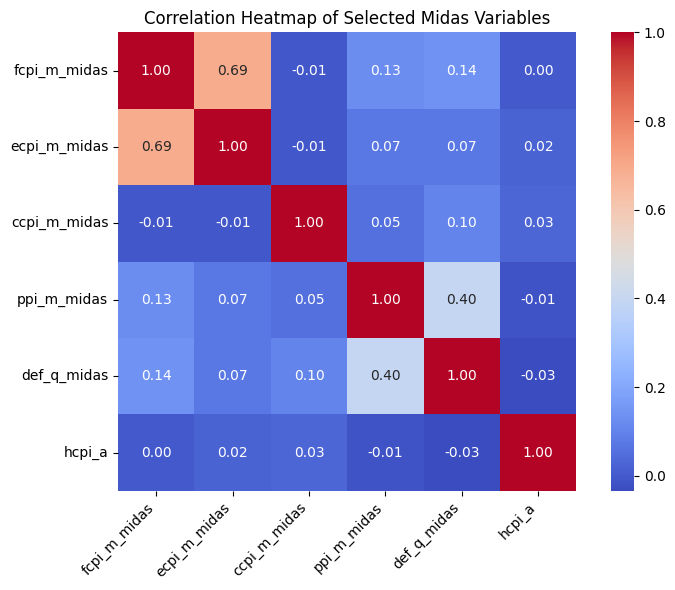

In [ ]:
import seaborn as sns

cols = [
    'fcpi_m_midas',
    'ecpi_m_midas',
    'ccpi_m_midas',
    'ppi_m_midas',
    'def_q_midas',
    'hcpi_a'
]

# Calculate the correlation coefficient matrix
corr = df_imputed[cols].corr()

# 
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,        
    fmt=".2f",         
    cmap="coolwarm",   
    square=True       
)
plt.title("Correlation Heatmap of Selected Midas Variables")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Train Model

In [17]:
# Feature column: All the original *_midas, plus post_covid
feature_cols = [c for c in df_imputed.columns if c.endswith('_midas')] + ['post_covid']

X      = df_imputed[feature_cols]
y      = df_imputed['hcpi_a']
groups = df_imputed['country']

# Training/testing by country (80/20)
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))
X_train, X_test = X.iloc[train_idx],   X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx],   y.iloc[test_idx]
groups_train    = groups.iloc[train_idx]

#  LinearRegression, RandomForest + CV, XGBoost + CV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1)  Linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2) random forest + GroupKFold CV
param_grid_rf = {
    'n_estimators':    [200,300,400],
    'max_depth':       [None, 5, 10],
    'min_samples_split':[2, 5,8]
}
cv = GroupKFold(n_splits=5)
grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=cv, scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train, groups=groups_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# 3) XGBoost + GroupKFold CV
param_grid_xgb = {
    'n_estimators':  [50, 100, 200],
    'max_depth':     [3, 5, 7],
    'learning_rate':[0.001, 0.01, 0.1],
    'subsample':     [0.6, 0.8, 1.0]
}
grid_xgb = GridSearchCV(
    XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        eval_metric='rmse'
    ),
    param_grid_xgb,
    cv=cv, scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train, groups=groups_train)
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Report the MSE and MAE of the three models
results = {
    'Linear':       (mean_squared_error(y_test, y_pred_lr),
                     mean_absolute_error(y_test, y_pred_lr)),
    'RandomForest': (mean_squared_error(y_test, y_pred_rf),
                     mean_absolute_error(y_test, y_pred_rf)),
    'XGBoost':      (mean_squared_error(y_test, y_pred_xgb),
                     mean_absolute_error(y_test, y_pred_xgb))
}


results_df = pd.DataFrame.from_dict(
    results, orient='index', columns=['MSE','MAE']
)
print(results_df)

                        MSE        MAE
Linear        123245.636463  87.709541
RandomForest   24442.678456  24.499973
XGBoost        24874.116648  28.603928


#### coefficients for Linaer Regression

In [15]:
# 1) Extract coefficients into a Series
coefficients = pd.Series(lr.coef_, index=X_train.columns)

# 2) Get the intercept
intercept = lr.intercept_

# 3) Display
print(f"Intercept: {intercept:.4f}\n")
print("Feature coefficients:")
print(coefficients.sort_values(ascending=False))

Intercept: 35.7111

Feature coefficients:
ecpi_m_midas    0.007206
ccpi_m_midas    0.000262
fcpi_m_midas   -0.013791
ppi_m_midas    -0.076005
def_q_midas    -0.180756
post_covid     -0.652586
dtype: float64


#### Feature importance

Random Forest feature importances (highest → lowest):

ecpi_m_midas    0.741913
def_q_midas     0.085385
fcpi_m_midas    0.072717
ppi_m_midas     0.070851
ccpi_m_midas    0.029124
post_covid      0.000011
dtype: float64 

XGBoost feature importances (highest → lowest):

ecpi_m_midas    0.490954
fcpi_m_midas    0.458115
def_q_midas     0.024369
ppi_m_midas     0.014524
ccpi_m_midas    0.011982
post_covid      0.000056
dtype: float32 



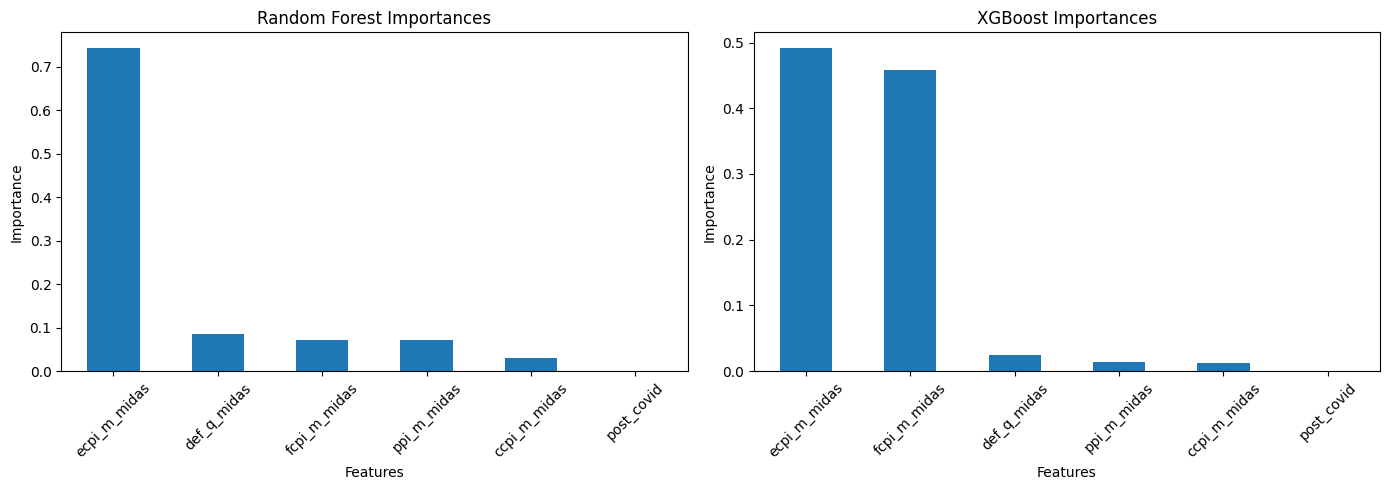

In [18]:
# 1) Extract feature names
feature_names = X_train.columns

# 2) Compute and sort importances
rf_importances = pd.Series(best_rf.feature_importances_, index=feature_names) \
                   .sort_values(ascending=False)
xgb_importances = pd.Series(best_xgb.feature_importances_, index=feature_names) \
                    .sort_values(ascending=False)

# 3) Print the rankings
print("Random Forest feature importances (highest → lowest):\n")
print(rf_importances, "\n")

print("XGBoost feature importances (highest → lowest):\n")
print(xgb_importances, "\n")

# 4) (Optional) Plot side‑by‑side bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

rf_importances.plot(
    kind='bar', ax=axes[0], 
    title='Random Forest Importances'
)
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Importance')
axes[0].tick_params(axis='x', rotation=45)

xgb_importances.plot(
    kind='bar', ax=axes[1], 
    title='XGBoost Importances'
)
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Importance')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Visualization for tuning

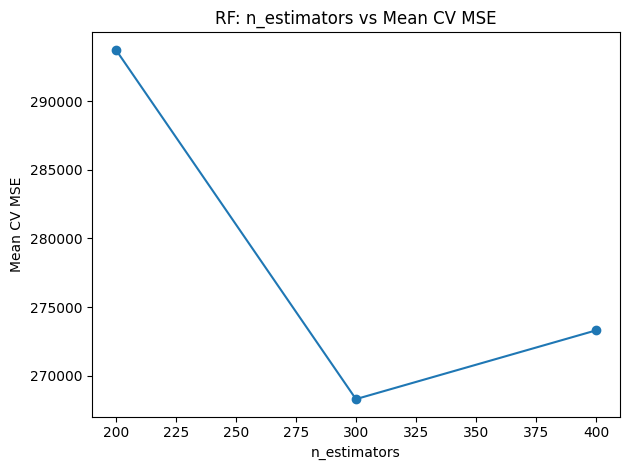

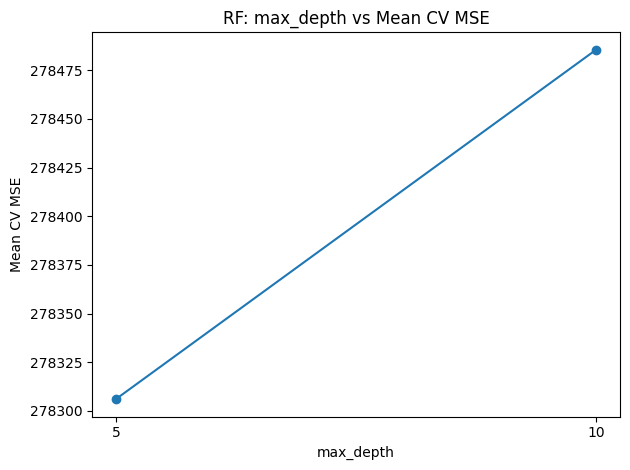

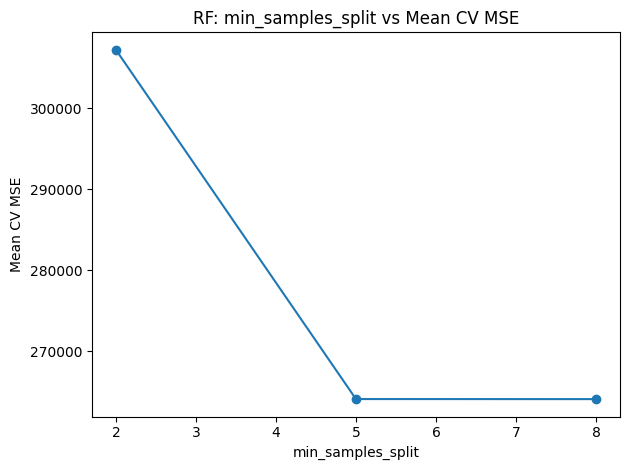

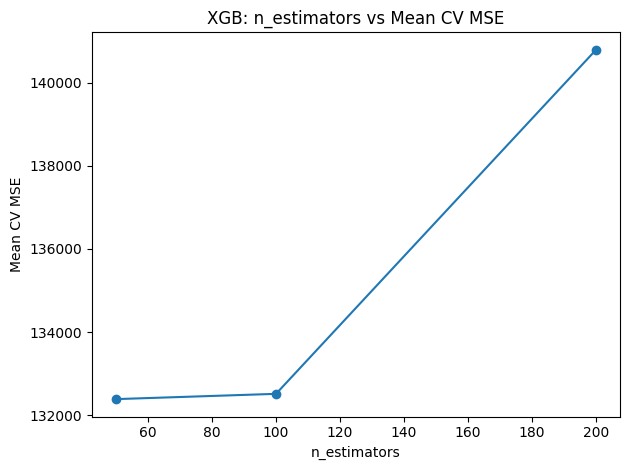

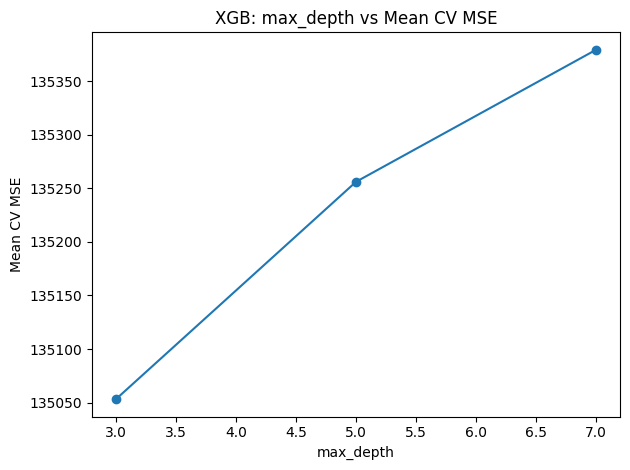

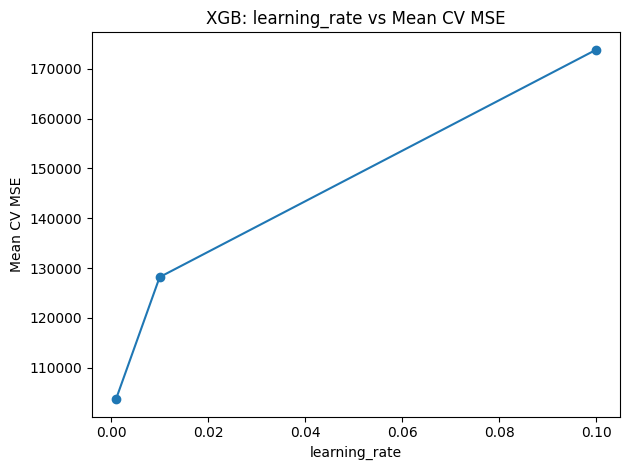

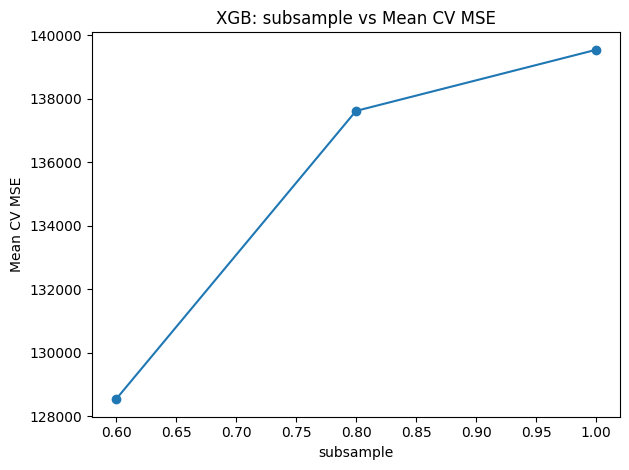

In [19]:
# 1) Random Forest hyperparameter tuning visualization
rf_results = pd.DataFrame(grid_rf.cv_results_)
# Convert negative MSE back to positive MSE
rf_results['mean_test_mse'] = -rf_results['mean_test_score']

# Plot effect of n_estimators
rf_ne = rf_results.groupby('param_n_estimators')['mean_test_mse'].mean()
plt.figure()
plt.plot(rf_ne.index.astype(int), rf_ne.values, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean CV MSE')
plt.title('RF: n_estimators vs Mean CV MSE')
plt.tight_layout()
plt.show()

# Plot effect of max_depth
rf_md = rf_results.groupby('param_max_depth')['mean_test_mse'].mean()
plt.figure()
plt.plot([str(d) for d in rf_md.index], rf_md.values, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean CV MSE')
plt.title('RF: max_depth vs Mean CV MSE')
plt.tight_layout()
plt.show()

# Plot effect of min_samples_split
rf_mss = rf_results.groupby('param_min_samples_split')['mean_test_mse'].mean()
plt.figure()
plt.plot(rf_mss.index.astype(int), rf_mss.values, marker='o')
plt.xlabel('min_samples_split')
plt.ylabel('Mean CV MSE')
plt.title('RF: min_samples_split vs Mean CV MSE')
plt.tight_layout()
plt.show()

# 2) XGBoost hyperparameter tuning visualization
xgb_results = pd.DataFrame(grid_xgb.cv_results_)
xgb_results['mean_test_mse'] = -xgb_results['mean_test_score']

# Plot effect of n_estimators
xgb_ne = xgb_results.groupby('param_n_estimators')['mean_test_mse'].mean()
plt.figure()
plt.plot(xgb_ne.index.astype(int), xgb_ne.values, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean CV MSE')
plt.title('XGB: n_estimators vs Mean CV MSE')
plt.tight_layout()
plt.show()

# Plot effect of max_depth
xgb_md = xgb_results.groupby('param_max_depth')['mean_test_mse'].mean()
plt.figure()
plt.plot(xgb_md.index.astype(int), xgb_md.values, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Mean CV MSE')
plt.title('XGB: max_depth vs Mean CV MSE')
plt.tight_layout()
plt.show()

# Plot effect of learning_rate
xgb_lr = xgb_results.groupby('param_learning_rate')['mean_test_mse'].mean()
plt.figure()
plt.plot(xgb_lr.index.astype(float), xgb_lr.values, marker='o')
plt.xlabel('learning_rate')
plt.ylabel('Mean CV MSE')
plt.title('XGB: learning_rate vs Mean CV MSE')
plt.tight_layout()
plt.show()

# Plot effect of subsample
xgb_ss = xgb_results.groupby('param_subsample')['mean_test_mse'].mean()
plt.figure()
plt.plot(xgb_ss.index.astype(float), xgb_ss.values, marker='o')
plt.xlabel('subsample')
plt.ylabel('Mean CV MSE')
plt.title('XGB: subsample vs Mean CV MSE')
plt.tight_layout()
plt.show()